In [32]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

In [33]:
bc = pd.read_csv('BTC-USD.csv')
bc.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1091,2019-12-13,7244.662109,7293.560547,7227.122559,7269.684570,7269.684570,17125736940
1092,2019-12-14,7268.902832,7308.836426,7097.208984,7124.673828,7124.673828,17137029729
1093,2019-12-15,7124.239746,7181.075684,6924.375977,7152.301758,7152.301758,16881129804
1094,2019-12-16,7153.663086,7171.168945,6903.682617,6932.480469,6932.480469,20213265949
1095,2019-12-17,6932.012207,6962.849121,6589.838379,6589.838379,6589.838379,22073120768


In [34]:
bc['Date'] = pd.to_datetime(bc.Date)
bc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [35]:
bc.set_index('Date', inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-17,785.166016,792.508972,784.864014,790.828979,790.828979,78989800
2016-12-18,791.007996,794.737000,788.026001,790.530029,790.530029,60524400
2016-12-19,790.692017,793.611023,790.320007,792.713989,792.713989,74886400
2016-12-20,792.247009,801.336975,791.497009,800.875977,800.875977,99629296
2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000


In [36]:
bc = bc[['Close']].loc['2017-01-01':]
bc.head()

,Close
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005


In [37]:
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(bc, fp)

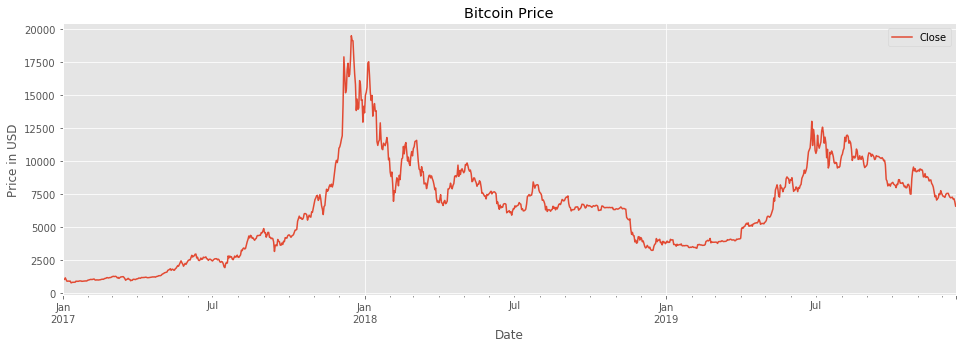

In [38]:
bc.plot(figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

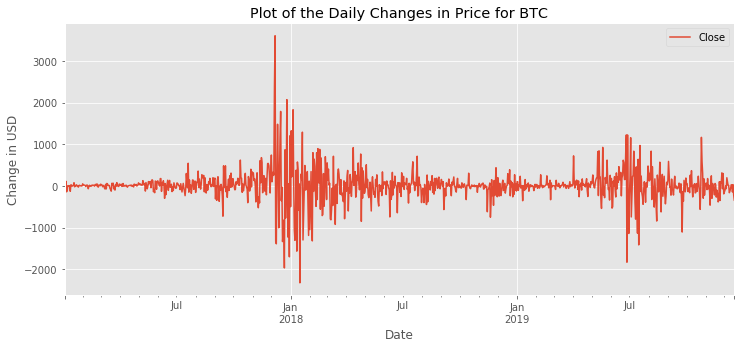

In [39]:
# Differencing the price
bc_diff = bc.diff(1).dropna()

# Plotting the differences daily
bc_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

In [40]:
results = adfuller(bc_diff.Close)
print(f"P-value: {results[1]}")

P-value: 2.9067794729380643e-08
